In [105]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import ast
import datetime
import seaborn as sns
from collections import Counter
from pprint import pprint
import numpy as np

In [106]:
df = pd.read_csv('main_task.xls')

<AxesSubplot:>

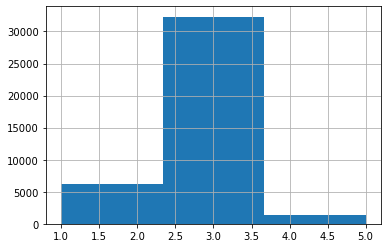

In [107]:
'''
Changing price values from $, $$-$$$, $$$$ into 1, 3 and 5 accordingly.
'''
def convert_price(string):
    if string == '$$$$':
        return 5
    elif string == '$':
        return 1
    else:
        return 3

df['Avg_Price'] = df['Price Range'].apply(convert_price)

In [108]:
'''
0. processing cuisines to first build a shorter list (down from 125)
1. checking which restaurants are serving national cuisines (based on the city)
2. counting number of cuisines served by each restaurant
3. building dummy list from the short cuisine list
4. creating new property of predicted quality based on ratio of served cuisines to price
'''

def build_top_list(series, top):
    cuisines = []
    for string in series:
        if type(string) == str:
            cuisines.extend(ast.literal_eval(string))
    return [x[0] for x in Counter(cuisines).most_common(top)]

def check_national_cuisines(series):
    city_national_cuisine = {'Paris': 'French',
                             'Stockholm': 'Swedish',
                             'London': 'British',
                             'Berlin': 'German',
                             'Munich': 'German',
                             'Oporto': 'Portuguese',
                             'Milan': 'Italian',
                             'Vienna': 'Austrian',
                             'Rome': 'Italian',
                             'Barcelona': 'Spanish',
                             'Madrid': 'Spanish',
                             'Dublin': 'Irish',
                             'Brussels': 'Belgian',
                             'Zurich': 'Swiss',
                             'Warsaw': 'Polish',
                             'Budapest': 'Hungarian',
                             'Copenhagen': 'Danish',
                             'Amsterdam': 'Dutch',
                             'Lyon': 'French',
                             'Hamburg': 'German',
                             'Lisbon': 'Portuguese',
                             'Prague': 'Czech',
                             'Oslo': 'Norwegian',
                             'Edinburgh': 'Scottish',
                             'Geneva': 'Swiss',
                             'Ljubljana': 'Slovenian',
                             'Athens': 'Greek',
                             'Luxembourg': 'Central European',
                             'Krakow': 'Polish',
                             }
    result = {}
    for idx, cuisines in series.iteritems():
        if type(cuisines) == str:
            city = df['City'][idx]
            if city_national_cuisine.get(city) in ast.literal_eval(cuisines):
                result[idx] = 1
            else:
                result[idx] = 0
        else:
            result[idx] = 0
    return pd.Series(result)

def regroup_cuisines(cuisines, top_list):
    if type(cuisines) == str:
        result = set()
        for cuisine in ast.literal_eval(cuisines):
        # regrouping some common cuisine categories
            if cuisine in ['Bar', 'Pub', 'Wine Bar']:
                result.add('Bar')
            elif cuisine in ['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options', 'Healthy']:
                result.add('Healthy')
            elif cuisine in ['Asian', 'Japanese', 'Sushi', 'Chinese', 'Thai']:
                result.add('Asian')
            elif cuisine in ['Fast Food', 'American']:
                result.add('Fast Food')
            # processing other most common cuisines
            elif cuisine in top_list:
                result.add(cuisine)
            # replacing all other cuisines with 'Others' category
            else:
                result.add('Others')
        return list(result)

top_list = build_top_list(df['Cuisine Style'], top=30)
df['Cuisine_National'] = check_national_cuisines(df['Cuisine Style'])
df['Cuisine_Styles_Short'] = df['Cuisine Style'].apply(lambda x: regroup_cuisines(x, top_list))
df['Cuisine_Style_Count'] = df['Cuisine_Styles_Short'].apply(lambda x: len(x) if type(x) == list else 2)

df_dummies = pd.get_dummies(df['Cuisine_Styles_Short'].apply(pd.Series).stack()).sum(level=0)
df = df.merge(df_dummies, left_index=True, right_index=True)

df['Cuisine_Predicted_Quality'] = df['Avg_Price'] / df['Cuisine_Style_Count']


In [ ]:
df['Avg_Price'].hist(bins=3)
